In [1]:
import aim_modules as am
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

## We want to find the right lambda schedule
## First let's look at 8 trials of 100ps of 11 lambdas. 


In [2]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["100ps"]
ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/11lams/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]
vdwLambdas = np.linspace(0.0,1.0,11)
coulLambdas = np.zeros(11)

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

In [3]:
# collect AIM results
import pandas as pd
home = "/Users/ChrisM/Documents/workspace/methane/AIM/"
times = ["100ps"]
aim_averages = {}
num_lams = 11
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = ["aim{0}11ls0{1}.out".format(j,i) for i in range(1,9)]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in files:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/methane/AIM/{0}".format(i)
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
        #hist_plot = am.hist_flatness(counts, i, 0, 0.2)
        
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg

ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/11lams/"
# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
num_lams = len(coulLambdas)
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/methaneTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

    
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
    ti_averages[j] = avg
    results[j]['TI'] = np.array(totals)
    results[j]['TI-CUBIC'] = np.array(cubics)
    
    
df_allk = {}
df_allk['AIM_VDW'] = aim_dgdvdwavg
df_allk['FIXED_VDW'] = ti_dgdvdwavg
df_allk['Coul_Lambdas'] = coulLambdas
df_allk['VdW_Lambdas'] = vdwLambdas

eleven_lambdas = pd.DataFrame.from_dict(df_allk)
eleven_results = results['100ps'].apply(np.vectorize(am.convert_to_kcal))
eleven_results['Number of Lambdas'] = 11

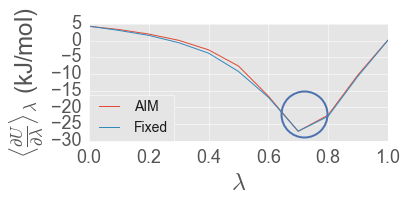

In [4]:
plt.figure(figsize=(6,3))
sns.lineplot(x="VdW_Lambdas", y="AIM_VDW", label="AIM", data=eleven_lambdas);
sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", data=eleven_lambdas);

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
#plt.title(j + " per $\lambda$");

point = [0.72,-22]
circle_rad = 23  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
plt.tick_params(axis=u'both', which=u'both',length=0)

sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Methane_11_lambdas_at_100ps_per_lambda.eps", dpi=600)
plt.show()

# Now 21 Lambdas

In [5]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["100ps"]
ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/21lams/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
import pandas as pd
home = "/Users/ChrisM/Documents/workspace/methane/AIM/"
times = ["100ps"]
aim_averages = {}
num_lams = 21
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = ["aim{0}21ls0{1}.out".format(j,i) for i in range(1,9)]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in files:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/methane/AIM/{0}".format(i)
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

    
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
            
        
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg


ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/21lams/"
# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
num_lams = len(coulLambdas)
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/methaneTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
    ti_averages[j] = avg

df_allk = {}
df_allk['AIM_VDW'] = aim_dgdvdwavg
df_allk['FIXED_VDW'] = ti_dgdvdwavg
df_allk['Coul_Lambdas'] = coulLambdas
df_allk['VdW_Lambdas'] = vdwLambdas

twentyone_lambdas = pd.DataFrame.from_dict(df_allk)
twentyone_results = results['100ps'].apply(np.vectorize(am.convert_to_kcal))
twentyone_results['Number of Lambdas'] = 21

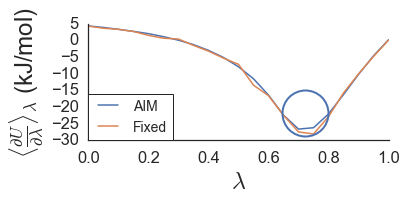

In [6]:
plt.figure(figsize=(6,3))
sns.lineplot(x="VdW_Lambdas", y="AIM_VDW", label="AIM", data=twentyone_lambdas);
sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", data=twentyone_lambdas);

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
#plt.title(j + " per $\lambda$");

point = [0.72,-22]
circle_rad = 23  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
sns.set()
# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
plt.tick_params(axis=u'both', which=u'both',length=0)
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Methane_21_lambdas_at_100ps_per_lambda.eps", dpi=600)
plt.show()

## Now 31 Lambdas

In [7]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["100ps"]
ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/31lams/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
import pandas as pd
home = "/Users/ChrisM/Documents/workspace/methane/AIM/"
times = ["100ps"]
aim_averages = {}
num_lams = 31
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = ["aim{0}31ls0{1}.out".format(j,i) for i in range(1,9)]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in files:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/methane/AIM/{0}".format(i)
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

    
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
            
        
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg
    

ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/31lams/"
# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
num_lams = len(coulLambdas)
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/methaneTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
    ti_averages[j] = avg

df_allk = {}

df_allk['AIM_VDW'] = aim_dgdvdwavg
df_allk['FIXED_VDW'] = ti_dgdvdwavg
df_allk['Coul_Lambdas'] = coulLambdas
df_allk['VdW_Lambdas'] = vdwLambdas

thirtyone_lambdas = pd.DataFrame.from_dict(df_allk)
thirtyone_results = results['100ps'].apply(np.vectorize(am.convert_to_kcal))
thirtyone_results['Number of Lambdas'] = 31

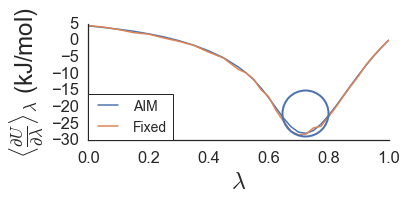

In [8]:
plt.figure(figsize=(6,3))
sns.lineplot(x="VdW_Lambdas", y="AIM_VDW", label="AIM", data=thirtyone_lambdas);
sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", data=thirtyone_lambdas);

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);

point = [0.72,-22]
circle_rad = 23  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
sns.set()
# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
plt.tick_params(axis=u'both', which=u'both',length=0)
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Methane_31_lambdas_at_100ps_per_lambda.eps", dpi=600)
plt.show()

/Users/ChrisM/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


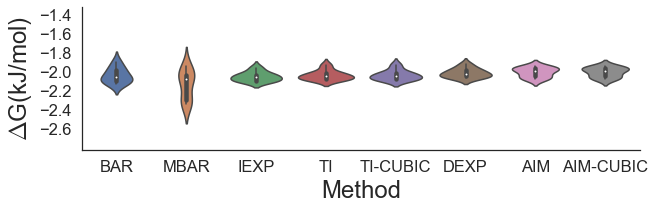

In [9]:
columns = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM',
       'AIM-CUBIC']
keys = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']

sns.catplot(data=thirtyone_results[columns], kind='violin',height=3,aspect=3);
plt.ylabel(r'$\Delta$G(kJ/mol)', fontsize = 24);
plt.xlabel(r'Method', fontsize = 24);
plt.ylim(-2.8, -1.3)
# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
plt.tick_params(axis=u'both', which=u'both',length=0)
#plt.title("ThirtyOne Lambdas @ 100 ps per $\lambda$");
plt.savefig("figures/Methane_31L_100ps_violin.eps",dpi=600)

# Convergence over time

### 31 Lambdas with multiple time per lambda

In [10]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["100ps","250ps","500ps","750ps","1ns"]


ti_home = "/Users/ChrisM/Documents/workspace/methane/TI/31lams/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
import pandas as pd
home = "/Users/ChrisM/Documents/workspace/methane/AIM/"
#times = ["1ns"]
aim_averages = {}
num_lams = 31
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = ["aim{0}31ls0{1}.out".format(j,i) for i in range(1,9)]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in files:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/methane/AIM/{0}".format(i)
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
            
        #hist_plot = am.hist_flatness(counts, i, 0, 0.2)
        
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg

In [11]:
keys = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']
# Plot the results using error bars for each lambda window
df = pd.DataFrame()
for i in keys:
    ddf = pd.DataFrame()
    ddf['100 ps'] = np.array(results['100ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['250 ps'] = np.array(results['250ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['500 ps'] = np.array(results['500ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['750 ps'] = np.array(results['750ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['1 ns'] = np.array(results['1ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['key'] = i
    df = pd.concat([df,ddf])

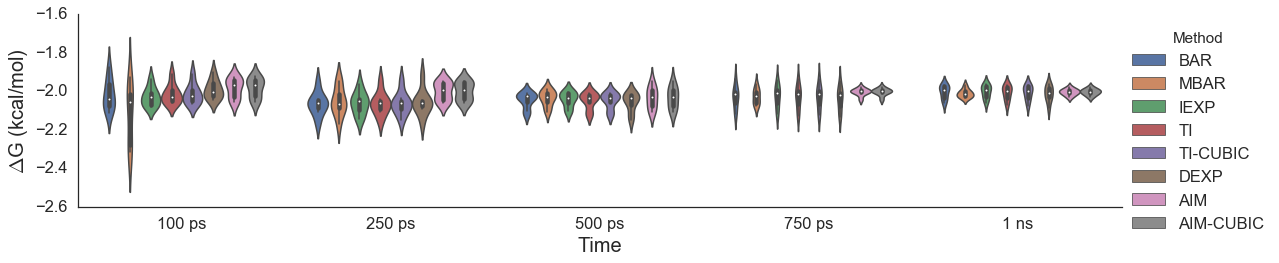

In [12]:
melted_df = pd.melt(df,
                   id_vars = 'key',
                   value_vars = ['100 ps','250 ps','500 ps','750 ps', '1 ns'],
                   var_name = 'Time',
                   value_name = 'DeltaG(kcal/mol)')

melted_df.columns = ['Method', 'Time','DeltaG(kcal/mol)']

g = sns.catplot(x="Time",
            y="DeltaG(kcal/mol)",
            hue="Method"
            ,data=melted_df,
            kind='violin',
            height=4,
            aspect=4,
            legend_out=True)

plt.ylabel("$\Delta$G (kcal/mol)", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
plt.tick_params(axis=u'both', which=u'both',length=0)
#plt.title("Methane 31 Lambdas", fontsize=20);

plt.savefig("figures/Methane_31L_violinplotovertime.eps",dpi=600)